# HPA Scaling Experiment Analysis (Enhanced with TTFT/ITL)

This notebook analyzes data from Horizontal Pod Autoscaler (HPA) scaling experiments with vLLM workloads, including performance metrics.

## Metrics Collected

The experiment monitors:
- **Replica counts** - Current and desired pod replicas
- **Waiting requests** - Number of requests in queue (vLLM metric)
- **KV cache usage** - GPU memory cache utilization percentage
- **TTFT (Time to First Token)** - Latency to first token in ms
- **ITL (Inter-Token Latency)** - Average latency between tokens in ms
- **Request Rate** - Throughput in requests/minute
- **Job status** - Active and completed load generation jobs
- **Scaling events** - When and why HPA scaled up/down

## Setup

Run this notebook after collecting experiment data with the enhanced monitor script.

# HPA Scaling Experiment Analysis

This notebook analyzes data from Horizontal Pod Autoscaler (HPA) scaling experiments with vLLM workloads.

## Overview

The experiment monitors:
- **Replica counts** - Current and desired pod replicas
- **Waiting requests** - Number of requests in queue (vLLM metric)
- **KV cache usage** - GPU memory cache utilization percentage
- **Job status** - Active and completed load generation jobs
- **Scaling events** - When and why HPA scaled up/down

## Setup

Run this notebook after collecting experiment data with `monitor-hpa-experiment.sh`.

## Quick Start Guide

1. **Set up environment**: Make sure you have the required packages installed:
   ```bash
   pip install pandas matplotlib jupyter
   ```

2. **Update the experiment directory path** in Section 2 (below)

3. **Run all cells**: Use "Run All" from the menu or execute cells sequentially

4. **Review the results**: 
   - Summary statistics
   - Visual plots
   - Scaling event details
   - Correlation analysis

---

## 1. Import Libraries

In [44]:
import json
import sys
from pathlib import Path
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Configure Experiment Directory

Set the path to your experiment data directory. This should be the output from `monitor-hpa-experiment.sh`.

In [45]:
# Option 1: Auto-detect latest experiment (recommended)
from pathlib import Path
data_dir = Path('../experiment-data')
if data_dir.exists():
    experiments = sorted(data_dir.glob('*-hpa-*'), reverse=True)
    if experiments:
        EXPERIMENT_DIR = str(experiments[0])
        print(f"✓ Auto-detected latest experiment: {experiments[0].name}")
    else:
        EXPERIMENT_DIR = './experiment-data/moderate-load-hpa-20251124-161753'
        print(f"⚠ No experiments found, using default: {EXPERIMENT_DIR}")
else:
    EXPERIMENT_DIR = './experiment-data/moderate-load-hpa-20251124-161753'
    print(f"⚠ Data directory not found, using default: {EXPERIMENT_DIR}")

# Set this to your experiment directory
# Option 2: Specify manually
# EXPERIMENT_DIR = './experiment-data/moderate-load-hpa-20251124-161753'

# Convert to Path object
exp_path = Path(EXPERIMENT_DIR)

if not exp_path.exists():
    print(f"❌ Error: Experiment directory not found: {EXPERIMENT_DIR}")
    print("\nAvailable experiments:")
    if data_dir.exists():
        experiments = sorted(data_dir.glob('*-hpa-*'), reverse=True)
        for exp in experiments[:10]:
            print(f"  - {exp.name}")
    print("\nPlease update EXPERIMENT_DIR manually in this cell.")
else:
    print(f"✓ Using experiment directory: {EXPERIMENT_DIR}")

✓ Auto-detected latest experiment: moderate-load-hpa-20251124-161753
✓ Using experiment directory: ../experiment-data/moderate-load-hpa-20251124-161753


## 3. Load Experiment Data

Load the metadata, metrics CSV, and scaling events from the experiment directory.

In [46]:
# Load metadata
metadata_file = exp_path / "metadata.json"
if metadata_file.exists():
    with open(metadata_file) as f:
        metadata = json.load(f)
    print("✓ Loaded metadata")
else:
    metadata = {}
    print("⚠ No metadata file found")

# Load metrics CSV
metrics_file = exp_path / "metrics.csv"
if not metrics_file.exists():
    raise FileNotFoundError(f"Metrics file not found: {metrics_file}")

df = pd.read_csv(metrics_file)
df['timestamp'] = pd.to_datetime(df['timestamp'])
print(f"✓ Loaded {len(df)} data points from metrics.csv")

# Load scaling events
scaling_log = exp_path / "scaling.log"
scaling_events = []
if scaling_log.exists():
    with open(scaling_log) as f:
        content = f.read()
        # Parse scaling events
        for block in content.split("========================================"):
            if "SCALING EVENT" in block:
                lines = block.strip().split('\n')
                scaling_events.append({
                    'text': block.strip(),
                    'lines': lines
                })
    print(f"✓ Found {len(scaling_events)} scaling events")
else:
    print("⚠ No scaling log found")

print("\nData loaded successfully!")

⚠ No metadata file found
✓ Loaded 47 data points from metrics.csv
⚠ No scaling log found

Data loaded successfully!


## 4. Experiment Summary

Display key information about the experiment.

In [47]:
print("=" * 70)
print("EXPERIMENT SUMMARY")
print("=" * 70)
print(f"Experiment Name: {metadata.get('experiment_name', 'N/A')}")
print(f"Start Time:      {metadata.get('start_time', 'N/A')}")
print(f"End Time:        {metadata.get('end_time', 'N/A')}")
print(f"Namespace:       {metadata.get('namespace', 'N/A')}")
print(f"HPA Name:        {metadata.get('hpa_name', 'N/A')}")
print(f"Deployment:      {metadata.get('deployment_name', 'N/A')}")
print()

print("=" * 70)
print("SCALING STATISTICS")
print("=" * 70)
print(f"Initial Replicas:  {df['replicas'].iloc[0]}")
print(f"Final Replicas:    {df['replicas'].iloc[-1]}")
print(f"Max Replicas:      {df['replicas'].max()}")
print(f"Min Replicas:      {df['replicas'].min()}")
print(f"Scaling Events:    {len(scaling_events)}")
print()

print("=" * 70)
print("METRIC STATISTICS")
print("=" * 70)

# Detect column names (handle both old and new formats)
waiting_col = next((col for col in ['num_requests_waiting', 'num_requests_waiting_current'] if col in df.columns), None)
cache_col = next((col for col in ['kv_cache_usage_perc', 'kv_cache_usage', 'kv_cache_usage_current'] if col in df.columns), None)
ttft_col = next((col for col in ['ttft_ms', 'ttft'] if col in df.columns), None)
itl_col = next((col for col in ['itl_ms', 'itl'] if col in df.columns), None)

print("Waiting Requests:")
if waiting_col:
    print(f"  Mean:   {df[waiting_col].mean():.2f}")
    print(f"  Max:    {df[waiting_col].max():.2f}")
    if 'num_requests_waiting_target' in df.columns:
        print(f"  Target: {df['num_requests_waiting_target'].iloc[0]}")
else:
    print("  Data not available")
print()

print("KV Cache Usage:")
if cache_col:
    print(f"  Mean:   {df[cache_col].mean():.2f}")
    print(f"  Max:    {df[cache_col].max():.2f}")
    if 'kv_cache_usage_target' in df.columns:
        print(f"  Target: {df['kv_cache_usage_target'].iloc[0]}")
else:
    print("  Data not available")
print()

# Show TTFT/ITL if available
if ttft_col:
    ttft_data = df[ttft_col][df[ttft_col] > 0]  # Filter out zeros
    if len(ttft_data) > 0:
        print("TTFT (Time to First Token) ms:")
        print(f"  Mean:   {ttft_data.mean():.2f}")
        print(f"  Max:    {ttft_data.max():.2f}")
        print(f"  Min:    {ttft_data.min():.2f}")
        print()
    else:
        print("TTFT: No data collected (all zeros - Prometheus may not be scraping vLLM metrics)")
        print()

if itl_col:
    itl_data = df[itl_col][df[itl_col] > 0]  # Filter out zeros
    if len(itl_data) > 0:
        print("ITL (Inter-Token Latency) ms:")
        print(f"  Mean:   {itl_data.mean():.2f}")
        print(f"  Max:    {itl_data.max():.2f}")
        print(f"  Min:    {itl_data.min():.2f}")
        print()
    else:
        print("ITL: No data collected (all zeros - Prometheus may not be scraping vLLM metrics)")
        print()

print("=" * 70)
print("JOB STATISTICS")
print("=" * 70)
if 'active_jobs' in df.columns:
    print(f"Max Active Jobs:    {df['active_jobs'].max()}")
if 'completed_jobs' in df.columns:
    print(f"Total Completed:    {df['completed_jobs'].iloc[-1]}")
elif 'active_jobs' in df.columns:
    print("Note: completed_jobs column not found in data")
print("=" * 70)

EXPERIMENT SUMMARY
Experiment Name: N/A
Start Time:      N/A
End Time:        N/A
Namespace:       N/A
HPA Name:        N/A
Deployment:      N/A

SCALING STATISTICS
Initial Replicas:  1
Final Replicas:    1
Max Replicas:      10
Min Replicas:      1
Scaling Events:    0

METRIC STATISTICS
Waiting Requests:
  Mean:   9.39
  Max:    117.00
  Target: 20

KV Cache Usage:
  Mean:   0.21
  Max:    0.99
  Target: 0.5

TTFT: No data collected (all zeros - Prometheus may not be scraping vLLM metrics)

ITL: No data collected (all zeros - Prometheus may not be scraping vLLM metrics)

JOB STATISTICS
Max Active Jobs:    0
Note: completed_jobs column not found in data


## 5. Data Preview

View the first few rows of the metrics data.

In [ ]:
# Display column names and data types
print("=" * 70)
print("AVAILABLE COLUMNS IN CSV")
print("=" * 70)
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col:40s} (type: {df[col].dtype})")

print("\n" + "="*70)
print("FIRST 10 ROWS")
print("="*70)
df.head(10)

AVAILABLE COLUMNS IN CSV
 1. timestamp                                (type: datetime64[ns])
 2. replicas                                 (type: int64)
 3. desired_replicas                         (type: int64)
 4. num_requests_waiting                     (type: float64)
 5. num_requests_waiting_target              (type: int64)
 6. kv_cache_usage_perc                      (type: float64)
 7. kv_cache_usage_target                    (type: float64)
 8. ttft_ms                                  (type: float64)
 9. itl_ms                                   (type: float64)
10. request_rate_per_min                     (type: float64)
11. active_jobs                              (type: int64)

FIRST 10 ROWS OF DATA


,timestamp,replicas,desired_replicas,num_requests_waiting,num_requests_waiting_target,kv_cache_usage_perc,kv_cache_usage_target,ttft_ms,itl_ms,request_rate_per_min,active_jobs
0,2025-11-24 16:17:59,1,1,0.0,20,0.000,0.5,0.0,0.0,0.0,0
1,2025-11-24 16:18:20,1,1,0.0,20,0.000,0.5,0.0,0.0,0.0,0
2,2025-11-24 16:18:41,1,1,0.0,20,0.000,0.5,0.0,0.0,0.0,0
3,2025-11-24 16:19:02,1,1,0.0,20,0.000,0.5,0.0,0.0,0.0,0
4,2025-11-24 16:19:23,1,1,0.0,20,0.039,0.5,0.0,0.0,0.0,0
5,2025-11-24 16:19:45,1,1,0.0,20,0.087,0.5,0.0,0.0,0.0,0
6,2025-11-24 16:20:06,1,1,0.0,20,0.087,0.5,0.0,0.0,0.0,0
7,2025-11-24 16:20:27,1,1,0.0,20,0.085,0.5,0.0,0.0,0.0,0
8,2025-11-24 16:20:48,1,1,0.0,20,0.062,0.5,0.0,0.0,0.0,0
9,2025-11-24 16:21:09,1,1,0.0,20,0.077,0.5,0.0,0.0,0.0,0


## 6. Visualizations

Individual plots for each metric, followed by a combined summary view.

In [ ]:
# Detect column names
waiting_col = next((col for col in ['num_requests_waiting', 'num_requests_waiting_current'] if col in df.columns), None)
cache_col = next((col for col in ['kv_cache_usage_perc', 'kv_cache_usage', 'kv_cache_usage_current'] if col in df.columns), None)
ttft_col = next((col for col in ['ttft_ms', 'ttft'] if col in df.columns), None)
itl_col = next((col for col in ['itl_ms', 'itl'] if col in df.columns), None)

# Calculate relative time (seconds from start)
df['time_relative'] = (df['timestamp'] - df['timestamp'].iloc[0]).dt.total_seconds()

📊 Generating individual metric plots...



### 6.1 Replica Scaling Over Time

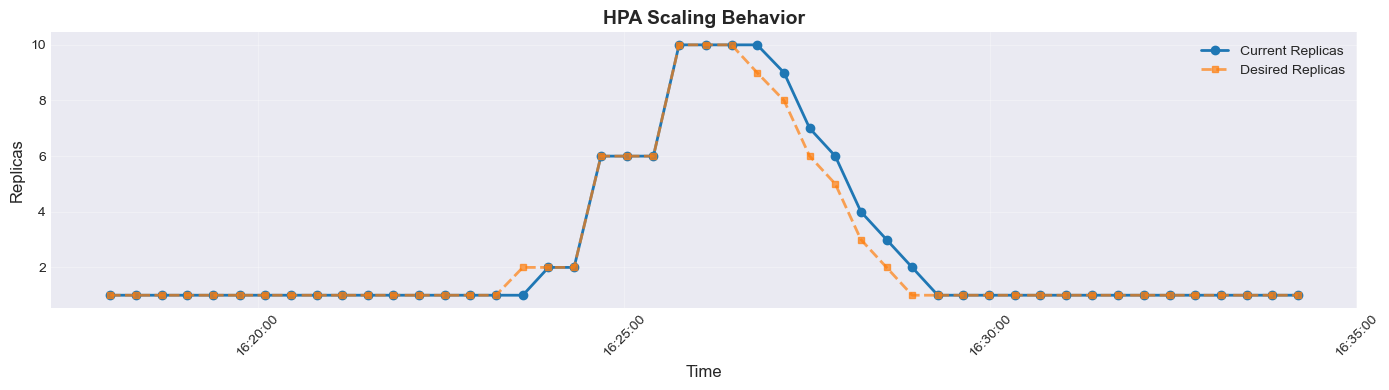

✅ Replica scaling plot complete


In [ ]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(df['time_relative'], df['replicas'], label='Current Replicas', marker='o', linewidth=2, markersize=6)
ax.plot(df['time_relative'], df['desired_replicas'], label='Desired Replicas', marker='s', linestyle='--', alpha=0.7, linewidth=2, markersize=5)
ax.set_xlabel('Time (seconds)', fontsize=12)
ax.set_ylabel('Replicas', fontsize=12)
ax.set_title('HPA Scaling Behavior', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 6.2 Request Queue Depth

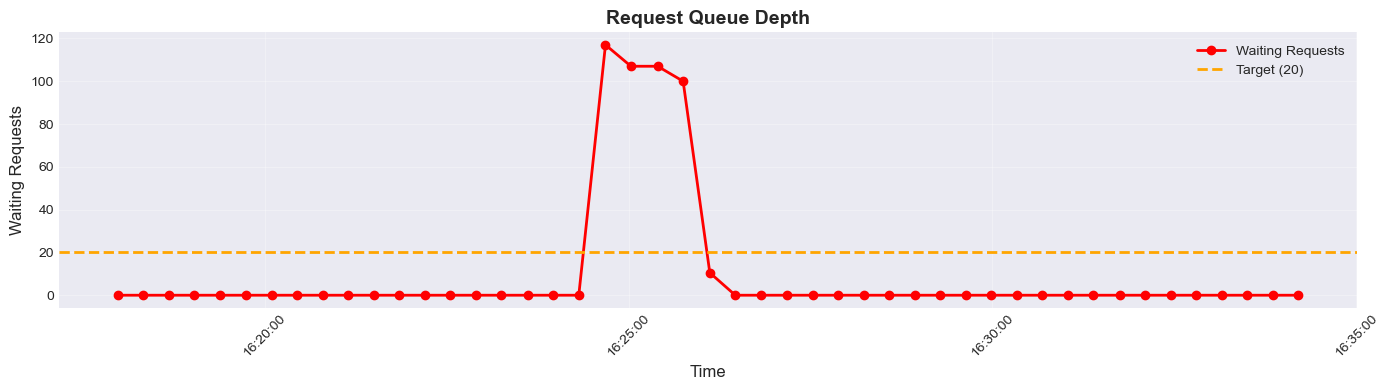

✅ Request queue plot complete


In [ ]:
if waiting_col:
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(df['time_relative'], df[waiting_col], label='Waiting Requests', color='red', marker='o', linewidth=2, markersize=6)
    if 'num_requests_waiting_target' in df.columns:
        ax.axhline(y=df['num_requests_waiting_target'].iloc[0], color='orange', linestyle='--', 
                   label=f'Target ({df["num_requests_waiting_target"].iloc[0]})', linewidth=2)
    ax.set_xlabel('Time (seconds)', fontsize=12)
    ax.set_ylabel('Waiting Requests', fontsize=12)
    ax.set_title('Request Queue Depth', fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    print("✅ Request queue plot complete")
else:
    print("⚠️  No waiting requests data available")

### 6.3 KV Cache Utilization

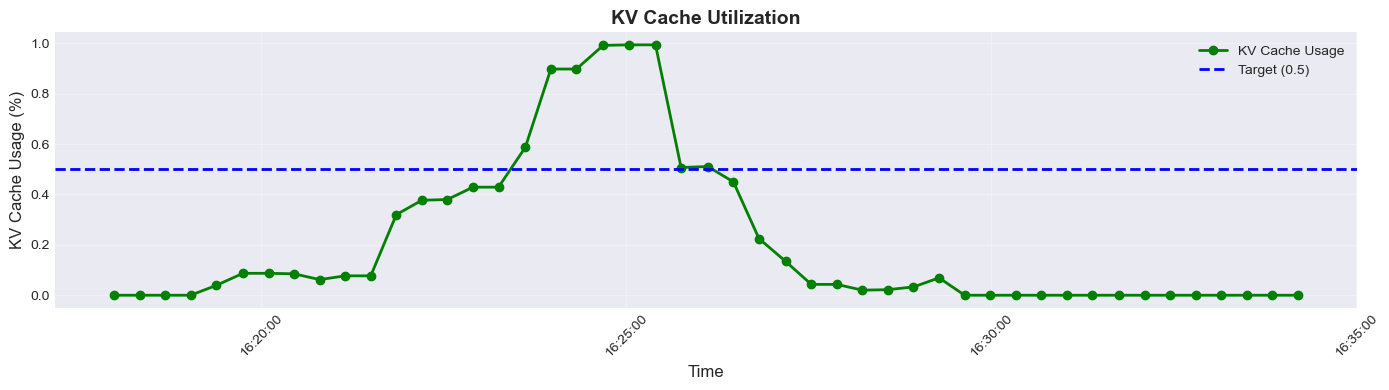

✅ KV cache plot complete


In [ ]:
if cache_col:
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(df['time_relative'], df[cache_col], label='KV Cache Usage', color='green', marker='o', linewidth=2, markersize=6)
    if 'kv_cache_usage_target' in df.columns:
        ax.axhline(y=df['kv_cache_usage_target'].iloc[0], color='blue', linestyle='--', 
                   label=f'Target ({df["kv_cache_usage_target"].iloc[0]})', linewidth=2)
    ax.set_xlabel('Time (seconds)', fontsize=12)
    ax.set_ylabel('KV Cache Usage (%)', fontsize=12)
    ax.set_title('KV Cache Utilization', fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    print("✅ KV cache plot complete")
else:
    print("⚠️  No KV cache data available")

### 6.4 Token Generation Latencies (TTFT & ITL)

In [ ]:
has_data = False

if ttft_col:
    ttft_data = df[ttft_col][df[ttft_col] > 0]  # Filter out zeros
    if len(ttft_data) > 0:
        has_data = True

if itl_col:
    itl_data = df[itl_col][df[itl_col] > 0]  # Filter out zeros
    if len(itl_data) > 0:
        has_data = True

if has_data:
    fig, ax = plt.subplots(figsize=(14, 4))
    
    if ttft_col and len(df[ttft_col][df[ttft_col] > 0]) > 0:
        ttft_mask = df[ttft_col] > 0
        ax.plot(df['time_relative'][ttft_mask], df[ttft_col][ttft_mask], label='TTFT (ms)', 
                color='purple', marker='o', linewidth=2, markersize=6, alpha=0.7)
    
    if itl_col and len(df[itl_col][df[itl_col] > 0]) > 0:
        itl_mask = df[itl_col] > 0
        ax.plot(df['time_relative'][itl_mask], df[itl_col][itl_mask], label='ITL (ms)', 
                color='brown', marker='s', linewidth=2, markersize=5, alpha=0.7)
    
    ax.set_xlabel('Time (seconds)', fontsize=12)
    ax.set_ylabel('Latency (ms)', fontsize=12)
    ax.set_title('Token Generation Latencies', fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    print("✅ TTFT/ITL plot complete")
else:
    print("⚠️  No TTFT/ITL data collected (all zeros - Prometheus may not be scraping vLLM metrics)")

⚠️  No TTFT/ITL data collected (all zeros - Prometheus may not be scraping vLLM metrics)


### 6.5 Combined Summary View

All metrics in a single 4-panel overview for comparison.

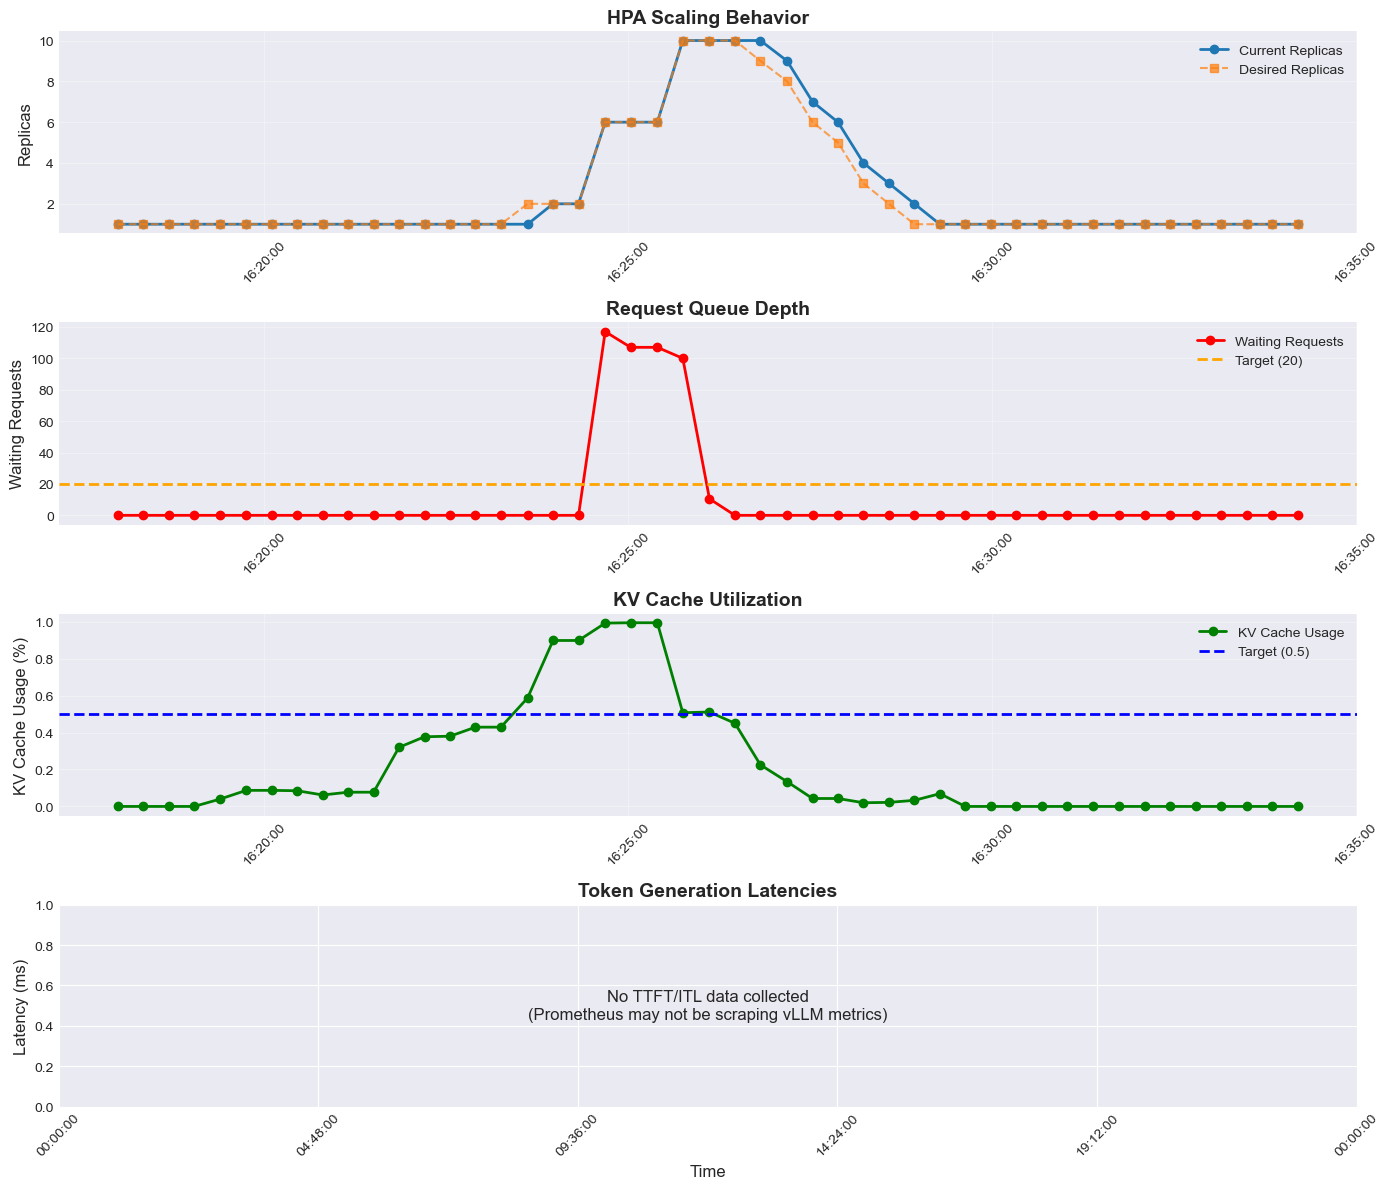


✅ Combined summary visualization complete!


In [54]:
# Create combined 4-panel plot
fig, axes = plt.subplots(4, 1, figsize=(14, 12))

# Panel 1: Replicas
ax1 = axes[0]
ax1.plot(df['timestamp'], df['replicas'], label='Current Replicas', marker='o', linewidth=2)
ax1.plot(df['timestamp'], df['desired_replicas'], label='Desired Replicas', marker='s', linestyle='--', alpha=0.7)
ax1.set_ylabel('Replicas', fontsize=12)
ax1.set_title('HPA Scaling Behavior', fontsize=14, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Panel 2: Waiting Requests
ax2 = axes[1]
if waiting_col:
    ax2.plot(df['timestamp'], df[waiting_col], label='Waiting Requests', color='red', marker='o', linewidth=2)
    if 'num_requests_waiting_target' in df.columns:
        ax2.axhline(y=df['num_requests_waiting_target'].iloc[0], color='orange', linestyle='--', 
                   label=f'Target ({df["num_requests_waiting_target"].iloc[0]})', linewidth=2)
    ax2.set_ylabel('Waiting Requests', fontsize=12)
    ax2.set_title('Request Queue Depth', fontsize=14, fontweight='bold')
    ax2.legend(loc='best')
    ax2.grid(True, alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'No waiting requests data available', ha='center', va='center', transform=ax2.transAxes)

# Panel 3: KV Cache Usage
ax3 = axes[2]
if cache_col:
    ax3.plot(df['timestamp'], df[cache_col], label='KV Cache Usage', color='green', marker='o', linewidth=2)
    if 'kv_cache_usage_target' in df.columns:
        ax3.axhline(y=df['kv_cache_usage_target'].iloc[0], color='blue', linestyle='--', 
                   label=f'Target ({df["kv_cache_usage_target"].iloc[0]})', linewidth=2)
    ax3.set_ylabel('KV Cache Usage (%)', fontsize=12)
    ax3.set_title('KV Cache Utilization', fontsize=14, fontweight='bold')
    ax3.legend(loc='best')
    ax3.grid(True, alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'No KV cache data available', ha='center', va='center', transform=ax3.transAxes)

# Panel 4: TTFT and ITL
ax4 = axes[3]
has_data = False

if ttft_col:
    ttft_data = df[ttft_col][df[ttft_col] > 0]
    if len(ttft_data) > 0:
        ax4.plot(df['timestamp'][df[ttft_col] > 0], ttft_data, label='TTFT (ms)', 
                color='purple', marker='o', linewidth=2, alpha=0.7)
        has_data = True

if itl_col:
    itl_data = df[itl_col][df[itl_col] > 0]
    if len(itl_data) > 0:
        ax4.plot(df['timestamp'][df[itl_col] > 0], itl_data, label='ITL (ms)', 
                color='brown', marker='s', linewidth=2, alpha=0.7)
        has_data = True

if has_data:
    ax4.set_ylabel('Latency (ms)', fontsize=12)
    ax4.set_title('Token Generation Latencies', fontsize=14, fontweight='bold')
    ax4.legend(loc='best')
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'No TTFT/ITL data collected\n(Prometheus may not be scraping vLLM metrics)', 
            ha='center', va='center', transform=ax4.transAxes, fontsize=12)
    ax4.set_ylabel('Latency (ms)', fontsize=12)
    ax4.set_title('Token Generation Latencies', fontsize=14, fontweight='bold')

# Format x-axis for all panels
for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    ax.tick_params(axis='x', rotation=45)

plt.xlabel('Time', fontsize=12)
plt.tight_layout()
plt.show()

print("\n✅ Combined summary visualization complete!")

## 7. Save Combined Summary Plot (Optional)

Uncomment and run to save the combined summary plot to a PNG file.

In [55]:
# Uncomment to save the combined summary plot
# output_file = exp_path / f"{metadata.get('experiment_name', 'experiment')}-summary.png"
# fig.savefig(output_file, dpi=300, bbox_inches='tight')
# print(f"✓ Combined summary plot saved to: {output_file}")

## 8. Scaling Events Details

View detailed information about each scaling event.

In [56]:
if scaling_events:
    print("=" * 70)
    print(f"SCALING EVENTS ({len(scaling_events)} total)")
    print("=" * 70)
    print()
    
    for i, event in enumerate(scaling_events, 1):
        print(f"Event {i}:")
        print("-" * 70)
        # Print first 600 characters of each event
        event_text = event['text']
        if len(event_text) > 600:
            print(event_text[:600] + "...")
        else:
            print(event_text)
        print()
else:
    print("No scaling events detected in this experiment.")

No scaling events detected in this experiment.


## 9. Additional Analysis: Metric Correlation

Analyze the relationship between metrics and scaling decisions.

In [57]:
# Detect column names (handle both old and new formats)
waiting_col = next((col for col in ['num_requests_waiting', 'num_requests_waiting_current'] if col in df.columns), None)
cache_col = next((col for col in ['kv_cache_usage_perc', 'kv_cache_usage', 'kv_cache_usage_current'] if col in df.columns), None)

# Calculate when each metric exceeded its threshold
if waiting_col and 'num_requests_waiting_target' in df.columns:
    df['waiting_requests_exceeded'] = df[waiting_col] > df['num_requests_waiting_target']
else:
    df['waiting_requests_exceeded'] = False

if cache_col and 'kv_cache_usage_target' in df.columns:
    df['kv_cache_exceeded'] = df[cache_col] > df['kv_cache_usage_target']
else:
    df['kv_cache_exceeded'] = False

df['any_threshold_exceeded'] = df['waiting_requests_exceeded'] | df['kv_cache_exceeded']

# Correlation between metrics
print("Metric Correlation Matrix:")
print("-" * 50)
correlation_cols = ['replicas']
if waiting_col:
    correlation_cols.append(waiting_col)
if cache_col:
    correlation_cols.append(cache_col)
if 'active_jobs' in df.columns:
    correlation_cols.append('active_jobs')

if len(correlation_cols) > 1:
    print(df[correlation_cols].corr().round(3))
else:
    print("Not enough columns for correlation analysis")
print()

# Count threshold violations
if waiting_col and 'num_requests_waiting_target' in df.columns:
    waiting_violations = df['waiting_requests_exceeded'].sum()
    total_samples = len(df)
    print(f"Threshold Violations:")
    print(f"  Waiting Requests > {df['num_requests_waiting_target'].iloc[0]}: {waiting_violations}/{total_samples} samples ({100*waiting_violations/total_samples:.1f}%)")

if cache_col and 'kv_cache_usage_target' in df.columns:
    kv_violations = df['kv_cache_exceeded'].sum()
    total_samples = len(df)
    if not (waiting_col and 'num_requests_waiting_target' in df.columns):
        print(f"Threshold Violations:")
    print(f"  KV Cache > {df['kv_cache_usage_target'].iloc[0]}: {kv_violations}/{total_samples} samples ({100*kv_violations/total_samples:.1f}%)")
print()

# Identify which metric triggered scaling
if len(scaling_events) > 0:
    print(f"Scaling Trigger Analysis:")
    print(f"  Total scaling events: {len(scaling_events)}")
    print(f"  Note: Check scaling-events.log for detailed trigger information")

Metric Correlation Matrix:
--------------------------------------------------
                      replicas  num_requests_waiting  kv_cache_usage_perc  \
replicas                 1.000                 0.459                0.404   
num_requests_waiting     0.459                 1.000                0.672   
kv_cache_usage_perc      0.404                 0.672                1.000   
active_jobs                NaN                   NaN                  NaN   

                      active_jobs  
replicas                      NaN  
num_requests_waiting          NaN  
kv_cache_usage_perc           NaN  
active_jobs                   NaN  

Threshold Violations:
  Waiting Requests > 20: 4/47 samples (8.5%)
  KV Cache > 0.5: 8/47 samples (17.0%)



## 10. Export Data for Further Analysis

Export processed data to CSV for use in other tools.

In [58]:
# Add analysis columns to the dataframe
df_export = df.copy()
df_export['waiting_requests_exceeded'] = df['waiting_requests_exceeded']
df_export['kv_cache_exceeded'] = df['kv_cache_exceeded']
df_export['any_threshold_exceeded'] = df['any_threshold_exceeded']

# Uncomment to export
# output_csv = exp_path / "analysis_results.csv"
# df_export.to_csv(output_csv, index=False)
# print(f"✓ Data exported to: {output_csv}")

print("Data ready for export. Uncomment the code above to save.")

Data ready for export. Uncomment the code above to save.


## Summary

This notebook provides a complete analysis of your HPA scaling experiment:

✅ **Data loaded** from experiment directory  
✅ **Summary statistics** calculated  
✅ **4-panel visualization** showing all key metrics  
✅ **Scaling events** extracted and displayed  
✅ **Correlation analysis** between metrics  
✅ **Export capability** for further analysis

### Next Steps

1. **Compare experiments**: Run this notebook on multiple experiment directories to compare different HPA configurations
2. **Tune thresholds**: Use the insights to adjust HPA target values
3. **Share results**: Export the plot and summary for documentation
4. **Deep dive**: Examine `scaling.log` for detailed event information

### Files in Experiment Directory

- `metrics.csv` - Time-series data (loaded in this notebook)
- `scaling.log` - Detailed scaling event information
- `events.log` - Kubernetes HPA events
- `jobs.log` - Load job status over time
- `metadata.json` - Experiment configuration
- `monitor.log` - Monitor script output